# **¿Qué factores afectan al precio del trigo en Argentina?**

En el contexto del mercado agrícola actual, es fundamental contar con herramientas que faciliten la comprensión de los factores que influyen en la variabilidad del precio de los commodities. Tanto los productores agrícolas como los inversores se beneficiarían al entender los elementos que afectan el precio del trigo. Este conocimiento les permitiría desarrollar estrategias efectivas en la producción y comercialización, así como tomar decisiones de inversión más fundamentadas.

Este proyecto se enfoca en analizar y modelar el precio del trigo en relación con tres factores clave:

**Precio del petróleo**: Evaluar cómo las fluctuaciones en el precio del petróleo impactan el costo de producción y, por ende, el precio del trigo.

**Precio del trigo global**: Investigar la correlación entre el precio del trigo en Argentina y el precio del trigo en mercados globales.

**Condiciones climáticas:** Analizar cómo los factores climaticos y estacionales afectan la oferta y demanda del trigo en Argentina.

**Tipo de cambio:** Examinar cómo las variaciones en el tipo de cambio influyen en el precio del trigo en dólares. Un peso argentino más débil frente al dólar puede aumentar los costos de produccion

Preguntas a Responder

**¿Varía el precio del trigo en función de las condiciones climáticas?**

**¿El precio del trigo se ve impactado directamente por el valor del petróleo?**

**¿Existe una correlación significativa entre el precio global del trigo y el precio del trigo en Argentina?**



**Contexto analítico**


Este data frame se compone de diversas fuentes de datos que han sido fusionadas para el posterior analisis, asi como variables calculadas que fueron agregadas para una vision mas clara. *Creando un data frame total de 7348 filas y 16 columnas.*

Los datos obtenidos son:

**Histórico de precios del trigo:** Datos del precio del trigo en argentina desde 2017 hasta 2024 obtenidos del BCR (Banco central de rosario).

**Datos climáticos:** Información proporcionada por la api METEOSTAT sobre la condicion del clima en las principales regiones productoras de trigo del país.

**Precios del petróleo:** Datos sobre el precio del petróleo a lo largo del período analizado en ARGENTINA, obtenido con la API libreria que interactua con la api de yahoo finance.

**Precios del petróleo GLOBAL** : Datos sobre el precio del petróleo a nivel mundial a lo largo del período analizado

**Datos del dólar oficial:** Informacion sobre el tipo de cambio del dólar oficial en Argentina durante el mismo período, recolectada de yahoo finance.

Las variables que conforman el data frame final son:

**Fecha**: Fecha de observación.

**Precio**: Precio del trigo en pesos argentinos.

**Precio_en_usd**: Precio del trigo en dólares estadounidenses.

**Precio_petroleo**: Precio del petróleo en dólares.

**tavg**: Temperatura promedio.

**tmin**: Temperatura mínima.

**tmax**: Temperatura máxima.

**prcp**: Precipitación en milímetros.

**wdir**: Dirección del viento.

**wspd**: Velocidad del viento.

**pres**: Presión atmosférica.

**Estacion**: Variable calculada para definir estaciones climáticas.

**Region:** Variable calculada para determinar el clima por región.

**Estacion**: Variable calculada para definir estaciones climáticas.

**categoria_prcp**: Categoría de precipitación (Baja, Media, Alta).

**categoria_temp**: Categoría de temperatura (Baja, Media, Alta).

# **Se realiza la carga y limpieza de distintas fuentes de datos**

In [ ]:

pip install meteostat #Se instala la libreria que consulta la api de meteostat para descargar datos del clima



In [ ]:
from meteostat import Point, Daily
from datetime import datetime
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

**Precios del trigo en ARS**


In [ ]:
url = 'https://github.com/Melanydaian/preentrega_Ds_amarillo/raw/main/preciostrigo2017.xlsx'
df_trigo = pd.read_excel(url)

print(df_trigo.head())
print(df_trigo.info())



            Unnamed: 0 Unnamed: 1 Unnamed: 2  Consulta de precios
0                  NaN        NaN        NaN                  NaN
1                  NaN        NaN        NaN                  NaN
2                Trigo        NaN        NaN                  NaN
3   Fecha de operación        NaN     Precio                  NaN
4  2017-01-02 10:12:00        NaN       2480                  NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1888 non-null   object 
 1   Unnamed: 1           430 non-null    object 
 2   Unnamed: 2           1887 non-null   object 
 3   Consulta de precios  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 59.2+ KB
None


In [ ]:
#Se renombran las columnas relevantes
df_trigo.rename(columns={'Unnamed: 0': 'fecha', 'Unnamed: 2': 'precio'}, inplace=True)

#Se eliminan columnas innecesarias
df_trigo_clean = df_trigo[['fecha', 'precio']]

#Se eliminan las filas donde 'fecha' no es una fecha válida
df_trigo_clean = df_trigo_clean[df_trigo_clean['precio'].apply(lambda x: str(x).isdigit())]

#Se convierte la columna de fecha a tipo datetime
df_trigo_clean['fecha'] = pd.to_datetime(df_trigo_clean['fecha'], errors='coerce')
df_trigo_clean['precio'] = pd.to_numeric(df_trigo_clean['precio'], errors='coerce') #el precio a tipo numerico
#se consultan nulos
print(df_trigo_clean.isnull().sum())
df_trigo_clean.info()
print(df_trigo_clean.head())


fecha     0
precio    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1886 entries, 4 to 1889
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   1886 non-null   datetime64[ns]
 1   precio  1886 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 44.2 KB
                fecha  precio
4 2017-01-02 10:12:00    2480
5 2017-01-03 10:14:00    2490
6 2017-01-04 10:15:00    2495
7 2017-01-05 10:15:00    2495
8 2017-01-06 10:21:00    2495


**Datos del clima**

In [ ]:
#Se obtienen datos del período de tiempo 2017 - 2024 de las principales regiones productoras de trigo en Argentina
start = datetime(2017, 1, 1)
end = datetime(2024, 12, 31)
regiones_trigo = {
    "Buenos Aires": Point(-34.6037, -58.3816, 25),
    "Córdoba": Point(-31.4201, -64.1888, 400),
    "Santa Fe": Point(-31.6097, -60.7000, 20),
    "La Pampa": Point(-36.6167, -64.2833, 200),
}

# Se crea un DataFrame vacío para almacenar los datos climáticos
df_clima_trigo = pd.DataFrame()

# Se recopilan los datos climáticos para cada región
for region, punto in regiones_trigo.items():
    try:
        # Se obtienen los datos climáticos diarios
        data = Daily(punto, start, end)
        data = data.fetch()

        # Se eliminan las columnas que contienen solo valores nulos
        data = data.dropna(axis=1, how='all')

        # Se agrega el nombre de la región para identificar los datos
        data['region'] = region

        # Concatenar los datos si no están vacíos
        if not data.empty:
            df_clima_trigo = pd.concat([df_clima_trigo, data])

    except Exception as e:
        print(f"Error al obtener datos para {region}: {e}")

# Primeras vistas del DataFrame
print(df_clima_trigo.head())
print(df_clima_trigo.info())

# Resumen de datos
print(f"Número total de registros: {df_clima_trigo.shape[0]}")


            tavg  tmin  tmax  prcp  snow   wdir  wspd    pres        region  \
time                                                                          
2017-01-01  30.2  27.4  34.9   0.0   NaN  232.0  11.1  1007.9  Buenos Aires   
2017-01-02  25.5  20.9  33.9   NaN   NaN  114.0  21.9  1011.8  Buenos Aires   
2017-01-03  26.1  23.6  28.3   NaN   NaN    3.0  14.9  1003.8  Buenos Aires   
2017-01-04  26.1  22.2  30.9   NaN   NaN  230.0   7.0  1004.6  Buenos Aires   
2017-01-05  25.0  19.6  30.7   NaN   NaN    NaN   9.9     NaN  Buenos Aires   

            wpgt  
time              
2017-01-01   NaN  
2017-01-02   NaN  
2017-01-03   NaN  
2017-01-04   NaN  
2017-01-05   NaN  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11370 entries, 2017-01-01 to 2024-10-13
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    11363 non-null  float64
 1   tmin    11264 non-null  float64
 2   tmax    10711 non-null  float64
 3

In [ ]:
#Se eliminan columnas con demasiados valores nulos en el DataFrame de clima
df_clima_trigo.drop(columns=['snow', 'wpgt'], inplace=True)

#Se rellenan los valores nulos restantes utilizando interpolación lineal
df_clima_trigo.interpolate(method='linear', inplace=True)
df_clima_trigo.reset_index(inplace=True)

#Se verifica la limpieza de los datos mostrando la cantidad de valores nulos restantes
print("\nValores nulos después de la limpieza:")
print(df_clima_trigo.isnull().sum())

#Se muestran las primeras filas del DataFrame limpio
print("\nDataFrame limpio:")
print(df_clima_trigo.head())






Valores nulos después de la limpieza:
time      0
tavg      0
tmin      0
tmax      0
prcp      0
wdir      0
wspd      0
pres      0
region    0
dtype: int64

DataFrame limpio:
        time  tavg  tmin  tmax       prcp   wdir  wspd    pres        region
0 2017-01-01  30.2  27.4  34.9   0.000000  232.0  11.1  1007.9  Buenos Aires
1 2017-01-02  25.5  20.9  33.9   4.285714  114.0  21.9  1011.8  Buenos Aires
2 2017-01-03  26.1  23.6  28.3   8.571429    3.0  14.9  1003.8  Buenos Aires
3 2017-01-04  26.1  22.2  30.9  12.857143  230.0   7.0  1004.6  Buenos Aires
4 2017-01-05  25.0  19.6  30.7  17.142857  136.5   9.9  1009.9  Buenos Aires


In [ ]:
#Se renombra y convierte la columna fecha a formato date
df_trigo_clean['fecha'] = pd.to_datetime(df_trigo_clean['fecha']).dt.date
df_clima_trigo['fecha'] = pd.to_datetime(df_clima_trigo['time']).dt.date

#Se elimina la columna 'time' ya que ahora se cuenta con la columna 'fecha'
df_clima_trigo.drop(columns=['time'], inplace=True)

#Se realiza el merge (inner join) de los datos climáticos con los precios de trigo basados en la columna de fecha
df_combined = pd.merge(df_trigo_clean, df_clima_trigo, on='fecha', how='inner')

print(df_combined.head())

# Se verifica cuántas fechas comunes se encontraron
fechas_comunes = len(df_combined)
print(f"Fechas comunes encontradas: {fechas_comunes}")




        fecha  precio  tavg  tmin  tmax      prcp        wdir       wspd  \
0  2017-01-02    2480  25.5  20.9  33.9  4.285714  114.000000  21.900000   
1  2017-01-02    2480  23.8  19.5  28.6  0.300000  326.000000   8.300000   
2  2017-01-02    2480  23.7  21.9  26.3  5.100000  314.282443  12.112723   
3  2017-01-02    2480  24.3  15.5  32.7  8.000000   83.668990  11.537631   
4  2017-01-03    2490  26.1  23.6  28.3  8.571429    3.000000  14.900000   

          pres        region  
0  1011.800000  Buenos Aires  
1  1011.000000       Córdoba  
2  1018.729389      Santa Fe  
3  1014.803136      La Pampa  
4  1003.800000  Buenos Aires  
Fechas comunes encontradas: 7544


In [ ]:
pip install yfinance

**Tipo de cambio**

In [ ]:
#Se descargan los datos históricos de USD/ARS desde 2017 hasta el presente
df_usd_ars = yf.download('ARS=X', start='2017-01-01', end='2024-12-31')
df_usd_ars.reset_index(inplace=True)

print(df_trigo_clean.isnull().sum()) #se verifican nulos

#Se renombra la columna 'Date' a 'fecha' y se convierte a formato datetime para poder fusioarla con el precio del trigo
df_usd_ars.rename(columns={'Date': 'fecha'}, inplace=True)
df_usd_ars['fecha'] = pd.to_datetime(df_usd_ars['fecha'])  # Asegura el formato datetime
df_trigo_clean['fecha'] = pd.to_datetime(df_trigo_clean['fecha'], errors='coerce')
print(df_usd_ars.head())
print(df_trigo_clean.head())



#Se realiza el merge de los datos de trigo con los datos de USD/ARS
df_combined = pd.merge(df_trigo_clean, df_usd_ars[['fecha', 'Adj Close']], on='fecha', how='left')
df_combined.rename(columns={'Adj Close': 'usd_ars'}, inplace=True)

#Se crea la nueva variable 'precio_en_usd', que convierte el precio de ARS a USD
df_combined['precio_en_usd'] = df_combined['precio'] / df_combined['usd_ars']

print(df_combined.head())
df_combined.to_csv('trigo_con_tipo_cambio_y_precio_en_usd.csv', index=False)


[*********************100%***********************]  1 of 1 completed

fecha     0
precio    0
dtype: int64
       fecha     Open       High      Low    Close  Adj Close  Volume
0 2017-01-02  15.8930  15.935200  15.7739  15.8930    15.8930       0
1 2017-01-03  15.9355  15.942000  15.8453  15.9345    15.9345       0
2 2017-01-04  15.9420  16.105000  15.8280  15.9350    15.9350       0
3 2017-01-05  16.0695  16.084299  15.9085  16.0805    16.0805       0
4 2017-01-06  15.9530  15.959000  15.8085  15.9510    15.9510       0
       fecha  precio
4 2017-01-02    2480
5 2017-01-03    2490
6 2017-01-04    2495
7 2017-01-05    2495
8 2017-01-06    2495
       fecha  precio  usd_ars  precio_en_usd
0 2017-01-02    2480  15.8930     156.043545
1 2017-01-03    2490  15.9345     156.264711
2 2017-01-04    2495  15.9350     156.573576
3 2017-01-05    2495  16.0805     155.156870
4 2017-01-06    2495  15.9510     156.416524


**Petróleo crudo (WTI)**

In [ ]:
#Se descargan los datos históricos del petróleo crudo WTI usando la libreria api de yfinance
df_petroleo = yf.download('CL=F', start='2017-01-01', end='2024-12-31')
df_petroleo.reset_index(inplace=True)
print(df_petroleo.isnull().sum()) #se verifican nulos
#Se convierte la columna 'Date' a formato de solo fecha y se renombra
df_petroleo['fecha'] = pd.to_datetime(df_petroleo['Date']).dt.date
df_petroleo.rename(columns={'Close': 'precio_petroleo'}, inplace=True)
df_petroleo['fecha'] = pd.to_datetime(df_petroleo['fecha'])

#Se seleccionan solo las columnas necesarias
df_petroleo = df_petroleo[['fecha', 'precio_petroleo']]

#Primeras vistas del data frame
display(df_petroleo.head())
print(df_petroleo.info())


[*********************100%***********************]  1 of 1 completed

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,fecha,precio_petroleo
0,2017-01-03,52.330002
1,2017-01-04,53.259998
2,2017-01-05,53.759998
3,2017-01-06,53.990002
4,2017-01-09,51.959999


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            1951 non-null   datetime64[ns]
 1   precio_petroleo  1951 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.6 KB
None


**Precio del trigo global**

In [ ]:
#Se descargan los datos históricos de precios del trigo global a traves de yfinance
df_trigo_global = yf.download('ZW=F', start='2017-01-01', end='2024-12-31')

#Se convierte el índice a una columna
df_trigo_global = df_trigo_global.reset_index()
print(df_trigo_global.head())

# Se renombra la columna 'Date' a 'fecha' y 'Adj Close' a 'precio_global'
df_trigo_global.rename(columns={'Date': 'fecha', 'Adj Close': 'precio_global'}, inplace=True)

# Se filtra el DataFrame para que contenga solo las columnas 'fecha' y 'precio_global'
df_trigo_global_filtered = df_trigo_global[['fecha', 'precio_global']]
df_trigo_global_filtered = df_trigo_global_filtered[(df_trigo_global_filtered['fecha'] >= '2017-01-01') & (df_trigo_global_filtered['fecha'] <= '2024-12-31')]
print(df_trigo_global_filtered.head())



[*********************100%***********************]  1 of 1 completed

        Date    Open    High     Low   Close  Adj Close  Volume
0 2017-01-03  408.75  414.00  405.75  406.50     406.50   65585
1 2017-01-04  406.50  419.00  404.75  418.50     418.50   59201
2 2017-01-05  418.75  427.00  416.25  426.25     426.25   86772
3 2017-01-06  425.75  428.00  421.75  423.25     423.25   64726
4 2017-01-09  424.75  428.25  421.00  427.25     427.25   69623
       fecha  precio_global
0 2017-01-03         406.50
1 2017-01-04         418.50
2 2017-01-05         426.25
3 2017-01-06         423.25
4 2017-01-09         427.25


# **Se realiza el merge de todos los data sets obtenidos ya limpios, y se suman variables calculadas para obtener el data frame final y realizar el EDA correspondiente**




In [ ]:

#Se Asegura de que la columna 'fecha' en el DataFrame de clima esté en formato datetime
df_clima_trigo['fecha'] = pd.to_datetime(df_clima_trigo['fecha'], errors='coerce')
df_combined['fecha'] = pd.to_datetime(df_combined['fecha'], errors='coerce')

#Se fusiona el dataset combinado con el de clima
df_combined_clima = pd.merge(
    df_combined,
    df_clima_trigo[['fecha', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'region']],
    on='fecha',
    how='left'
)

#Se fusiona el dataset combinado con el precio del petróleo
df_combined_clima_petroleo = pd.merge(
    df_combined_clima,
    df_petroleo[['fecha', 'precio_petroleo']],
    on='fecha',
    how='left'
)

#Se Fusiona el dataset combinado con el precio global del trigo
df_combined_final = pd.merge(
    df_combined_clima_petroleo,
    df_trigo_global_filtered,
    on='fecha',
    how='left'
)

#Se filtran las columnas necesarias
df_combined_final = df_combined_final[['fecha', 'precio', 'usd_ars', 'precio_en_usd', 'precio_petroleo', 'precio_global', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'region']]

#Categorización de la precipitación
bins_prcp = [-1, 5, 15, float('inf')]
labels_prcp = ['Baja', 'Media', 'Alta']
df_combined_final['categoria_prcp'] = pd.cut(df_combined_final['prcp'], bins=bins_prcp, labels=labels_prcp)

#Categorización de las temperaturas
bins_temp = [-float('inf'), 15, 25, float('inf')]
labels_temp = ['Baja', 'Media', 'Alta']
df_combined_final['categoria_temp'] = pd.cut(df_combined_final['tavg'], bins=bins_temp, labels=labels_temp)
df_combined_final = df_combined_final[df_combined_final['precio_petroleo'].notna()]

#Se asignan estaciones del año
def obtener_estacion(fecha):
    mes = fecha.month
    dia = fecha.day

    if (mes == 12 and dia >= 21) or (mes in [1, 2]) or (mes == 3 and dia < 21):
        return 'Verano'
    elif (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Otoño'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Invierno'
    else:
        return 'Primavera'

df_combined_final['estacion'] = df_combined_final['fecha'].apply(obtener_estacion)
print(df_combined_final.head())
print(f"Tamaño del DataFrame final: {df_combined_final.shape}")
print(df_combined_final.columns)



       fecha  precio  usd_ars  precio_en_usd  precio_petroleo  precio_global  \
4 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
5 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
6 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
7 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
8 2017-01-04    2495  15.9350     156.573576        53.259998          418.5   

   tavg  tmin  tmax       prcp        wdir       wspd         pres  \
4  26.1  23.6  28.3   8.571429    3.000000  14.900000  1003.800000   
5  28.5  21.7  38.2   0.000000   51.000000  14.600000  1003.600000   
6  26.0  22.1  31.3  23.100000  313.938931  12.115267  1018.715267   
7  23.5  17.4  33.4  11.900000   84.076655  11.541812  1014.803484   
8  26.1  22.2  30.9  12.857143  230.000000   7.000000  1004.600000   

         region categoria_prcp categoria_temp estacion  
4  Buenos Aires          Media           

In [ ]:
df_combined_final.describe()
df_combined_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7348 entries, 4 to 7543
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            7348 non-null   datetime64[ns]
 1   precio           7348 non-null   int64         
 2   usd_ars          7336 non-null   float64       
 3   precio_en_usd    7336 non-null   float64       
 4   precio_petroleo  7348 non-null   float64       
 5   precio_global    7348 non-null   float64       
 6   tavg             7348 non-null   float64       
 7   tmin             7348 non-null   float64       
 8   tmax             7348 non-null   float64       
 9   prcp             7348 non-null   float64       
 10  wdir             7348 non-null   float64       
 11  wspd             7348 non-null   float64       
 12  pres             7348 non-null   float64       
 13  region           7348 non-null   object        
 14  categoria_prcp   7348 non-null   category    

In [ ]:
#Se convierten columnas relevantes a tipo numérico
num_columns = ['precio', 'precio_en_usd', 'precio_petroleo', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

for col in num_columns:
    df_combined_final[col] = pd.to_numeric(df_combined_final[col], errors='coerce')


#Se convierten estacion y region a tipo categórico
df_combined_final['estacion'] = df_combined_final['estacion'].astype('category')
df_combined_final['region'] = df_combined_final['region'].astype('category')
print(df_combined_final.dtypes)
print(df_combined_final.head())
df_combined_final.describe()

fecha              datetime64[ns]
precio                      int64
usd_ars                   float64
precio_en_usd             float64
precio_petroleo           float64
precio_global             float64
tavg                      float64
tmin                      float64
tmax                      float64
prcp                      float64
wdir                      float64
wspd                      float64
pres                      float64
region                   category
categoria_prcp           category
categoria_temp           category
estacion                 category
dtype: object
       fecha  precio  usd_ars  precio_en_usd  precio_petroleo  precio_global  \
4 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
5 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
6 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
7 2017-01-03    2490  15.9345     156.264711        52.330002          406.5   
8 2017-0

,fecha,precio,usd_ars,precio_en_usd,precio_petroleo,precio_global,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,7348,7348.000000,7336.000000,7336.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000,7348.000000
mean,2020-11-14 02:19:31.910723840,42453.862275,173.805698,225.579058,65.854350,600.327980,17.877280,12.195271,24.629478,4.072024,150.435256,13.342797,1015.304245
min,2017-01-03 00:00:00,0.000000,15.114000,0.000000,-37.630001,387.250000,1.300000,-7.800000,5.900000,0.000000,0.000000,3.000000,973.800000
25%,2018-12-03 00:00:00,7400.000000,37.625999,185.816447,53.130001,496.000000,13.200000,7.600000,19.400000,0.000000,61.000000,9.900000,1011.200000
50%,2020-11-11 00:00:00,17030.000000,79.461800,212.944248,65.910004,555.000000,18.100000,12.500000,24.800000,0.027150,142.000000,12.692256,1014.898432
75%,2022-10-24 00:00:00,53400.000000,154.670364,247.798107,77.739998,677.000000,22.700000,17.200000,29.800000,3.712500,220.733449,15.700000,1018.600000
max,2024-09-27 00:00:00,249000.000000,968.495117,436.595447,123.699997,1425.250000,34.000000,27.900000,42.700000,177.000000,360.000000,38.500000,1395.800000
std,NaN,60204.672594,252.593714,55.126323,18.048055,156.433277,6.123907,6.425750,6.710010,9.756404,103.269846,4.925138,7.333134


In [ ]:
#Se filtra el DataFrame para eliminar filas donde el precio en USD sea cero
df_combined_final = df_combined_final[df_combined_final['precio_en_usd'] > 0]
df_combined_final.describe()

,fecha,precio,usd_ars,precio_en_usd,precio_petroleo,precio_global,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,7332,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000
mean,2020-11-15 01:02:50.867430656,42538.917076,173.700940,225.702124,65.872466,600.526869,17.880462,12.196638,24.633560,4.070374,150.447800,13.343856,1015.301463
min,2017-01-03 00:00:00,2230.000000,15.114000,142.733704,-37.630001,387.250000,1.300000,-7.800000,5.900000,0.000000,0.000000,3.000000,973.800000
25%,2018-12-04 00:00:00,7410.000000,37.625999,185.823962,53.130001,496.500000,13.200000,7.600000,19.400000,0.000000,61.000000,9.900000,1011.200000
50%,2020-11-12 00:00:00,17100.000000,79.422699,212.956655,65.949997,555.000000,18.100000,12.500000,24.800000,0.021429,142.000000,12.689059,1014.897735
75%,2022-10-24 00:00:00,54100.000000,153.822098,247.798107,77.769997,678.500000,22.700000,17.200000,29.800000,3.702083,221.000000,15.700000,1018.600000
max,2024-09-27 00:00:00,249000.000000,968.495117,436.595447,123.699997,1425.250000,34.000000,27.900000,42.700000,177.000000,360.000000,38.500000,1395.800000
std,NaN,60242.589395,252.622777,54.888885,18.059042,156.512276,6.120722,6.425457,6.705202,9.758952,103.321057,4.927956,7.334292


# **Visualizaciones**

In [ ]:
#Se realiza un Gráfico de barras del precio medio del trigo en USD por categoría de precipitación
plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined_final, x='categoria_prcp', y='precio_en_usd', estimator='mean', errorbar=None, color='orange')
plt.title('Precio Medio del Trigo en USD por Categoría de Precipitación')
plt.xlabel('Categoría de Precipitación')
plt.ylabel('Precio Medio en USD')
plt.show()





NameError: name 'plt' is not defined

*Se observa que los precios son bastante similares en las tres categorías de precipitación. Sin embargo, se puede notar una ligera tendencia hacia un precio medio más alto en la categoría de Baja precipitación, lo que sugiere que hay menos oferta disponible en el mercado. Las condiciones de baja precipitación pueden limitar la producción del trigo, lo que a su vez puede llevar a un aumento en los precios debido a la ley de oferta y demanda.*


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



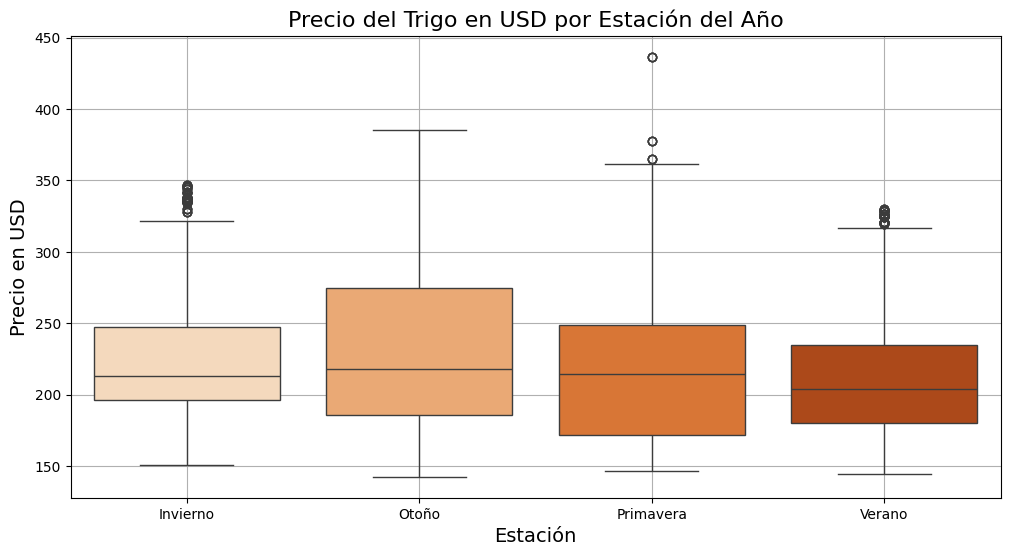

In [ ]:
# boxplot del precio del trigo en USD por estación del año
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined_final, x='estacion', y='precio_en_usd', palette='Oranges')
plt.title('Precio del Trigo en USD por Estación del Año', fontsize=16)
plt.xlabel('Estación', fontsize=14)
plt.ylabel('Precio en USD', fontsize=14)
plt.grid()
plt.show()



*Se observa que los precios del trigo son los más bajos en verano y más altos en otoño. Este patrón se puede explicar porque en temperaturas altas y la falta de precipitaciones el trigo entra en estres hidrico, lo que afecta la caliad del trigo y reduce su precio en consecuencia. Ademas, por la dinámica de la oferta y la demanda en el mercado. Durante la primavera y principios del verano, se produce la mayoria de la cosecha del trigo, lo que resulta en una mayor disponibilidad del producto en el mercado. Esta abundancia tiende a aumentar la oferta, lo que generalmente presiona a la baja los precios. Por otro lado, en otoño, la oferta de trigo disminuye ya que los cultivos están en proceso de siembra, lo que provoca un incremento en los precios debido a la menor disponibilidad del producto en comparación con la demanda existente.*

In [ ]:
#Se realiza el proceso para interpretar los outliers
Q1 = df_combined_final['precio_en_usd'].quantile(0.25)
Q3 = df_combined_final['precio_en_usd'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_combined_final[(df_combined_final['precio_en_usd'] < limite_inferior) |
                              (df_combined_final['precio_en_usd'] > limite_superior)]
print("Outliers identificados:")
print(outliers)


Outliers identificados:
          fecha  precio     usd_ars  precio_en_usd  precio_petroleo  \
5140 2022-04-18   39500  113.833351     346.998482       108.209999   
5141 2022-04-18   39500  113.833351     346.998482       108.209999   
5142 2022-04-18   39500  113.833351     346.998482       108.209999   
5143 2022-04-18   39500  113.833351     346.998482       108.209999   
5144 2022-04-19   40250  114.175934     352.526129       102.559998   
...         ...     ...         ...            ...              ...   
6759 2023-12-11  130000  364.432220     356.719282        71.320000   
6764 2023-12-13  160000  366.471985     436.595447        69.470001   
6765 2023-12-13  160000  366.471985     436.595447        69.470001   
6766 2023-12-13  160000  366.471985     436.595447        69.470001   
6767 2023-12-13  160000  366.471985     436.595447        69.470001   

      precio_global  tavg  tmin  tmax  prcp   wdir  wspd    pres  \
5140        1120.50  19.0  17.1  21.0   0.8   76.0  16.

*La mayoria de los outliers son esperados, y parecen darse en los cambios abruptos en el tipo de cambio, como en diciembre 2023 cuando hubo un cambio de politicas en Argentina lo que generó una alta volatilidad en el mercado cambiario.*

<Figure size 1200x600 with 0 Axes>

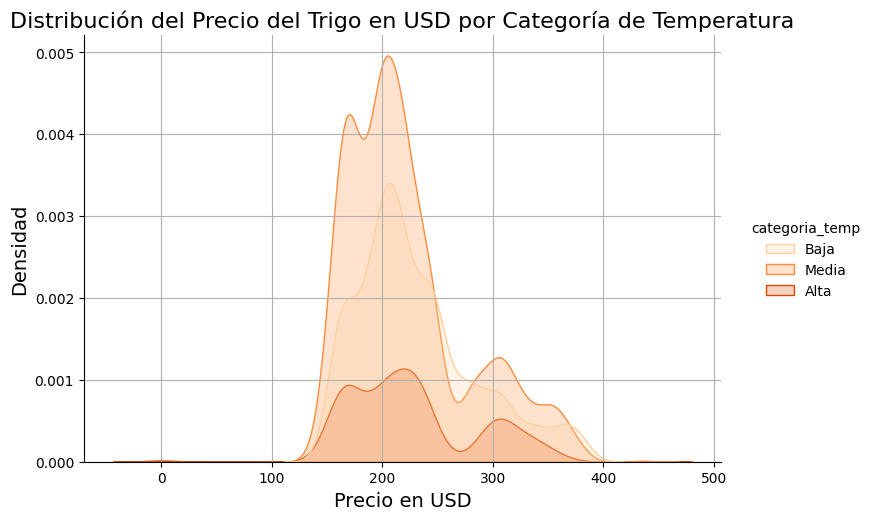

In [ ]:

plt.figure(figsize=(12, 6))
sns.displot(data=df_combined_final, x='precio_en_usd', hue='categoria_temp', kind='kde', fill=True, aspect=1.5, palette='Oranges')
plt.title('Distribución del Precio del Trigo en USD por Categoría de Temperatura', fontsize=16)
plt.xlabel('Precio en USD', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.grid()
plt.show()


*La distribución para las altas temperaturas presenta un patrón interesante. Se observa nuevamente que los precios del trigo tienden a ser más bajos en esta categoría. La densidad alcanza su pico en el rango inferior de precios, indicando que en condiciones de altas temperaturas, el precio del trigo suele ser más bajo, por otro lado, en temperaturas medias, el precio tiende a subir,alcanzando picos más altos en comparación con la categoría baja.*

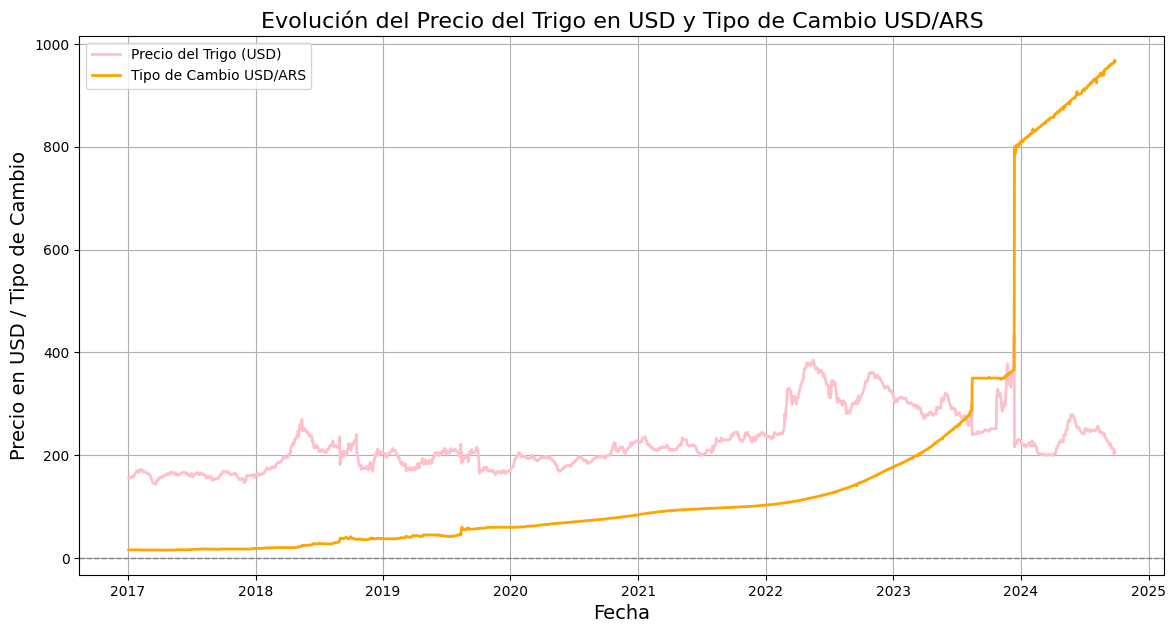

In [ ]:

#Se grafican el precio del trigo en usd y el tipo de cambio

plt.figure(figsize=(14, 7))
plt.plot(df_combined_final['fecha'], df_combined_final['precio_en_usd'], label='Precio del Trigo (USD)', color='pink', linewidth=2)
plt.plot(df_combined_final['fecha'], df_combined_final['usd_ars'], label='Tipo de Cambio USD/ARS', color='orange', linewidth=2)

plt.title('Evolución del Precio del Trigo en USD y Tipo de Cambio USD/ARS', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio en USD / Tipo de Cambio', fontsize=14)
plt.axhline(0, color='grey', lw=1, ls='--')
plt.legend()
plt.grid()
plt.show()




*La relación entre ambas líneas sugiere que a medida que el tipo de cambio USD/ARS aumenta (es decir, el peso se debilita), el precio del trigo en USD también tiende a aumentar. Esto podría indicar que una mayor devaluación del peso argentino lleva a un incremento en el costo del trigo en términos de dólares, ya que el trigo se comercializa en este último.*

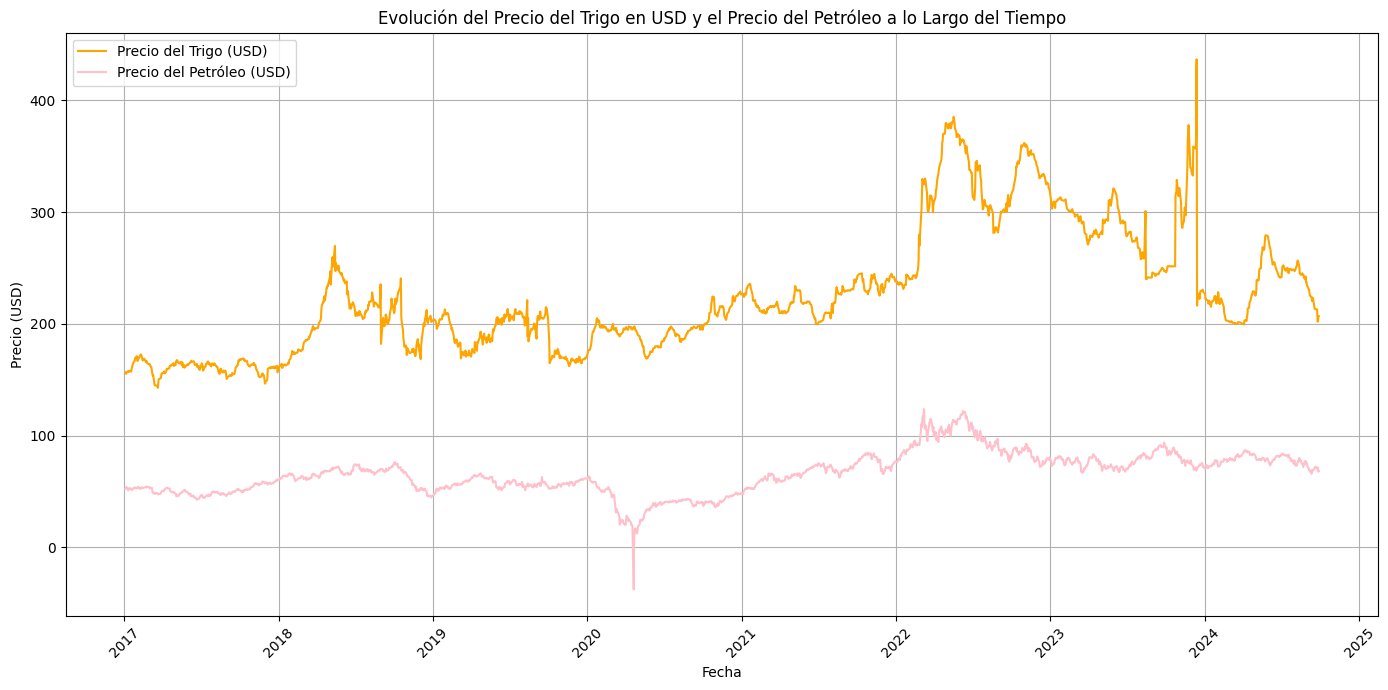

In [ ]:
#comparacion entre el precio del trigo en usd y el valor del petroleo a lo largo del tiempo
df_combined_final = df_combined_final[df_combined_final['precio_en_usd'] != 0]
plt.figure(figsize=(14, 7))
plt.plot(df_combined_final['fecha'], df_combined_final['precio_en_usd'], label='Precio del Trigo (USD)', color='orange')
plt.plot(df_combined_final['fecha'], df_combined_final['precio_petroleo'], label='Precio del Petróleo (USD)', color='pink')
plt.title('Evolución del Precio del Trigo en USD y el Precio del Petróleo a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



*La interacción entre el precio del trigo y el petróleo es notable. Aunque el precio del petróleo tiende a ser más estable, se puede observar que las fluctuaciones en el costo del petróleo afectan significativamente el valor del trigo. Esto sugiere que cambios en el precio del petróleo, que impactan los costos de producción y transporte, pueden tener un efecto directo en el precio del trigo en el mercado.*

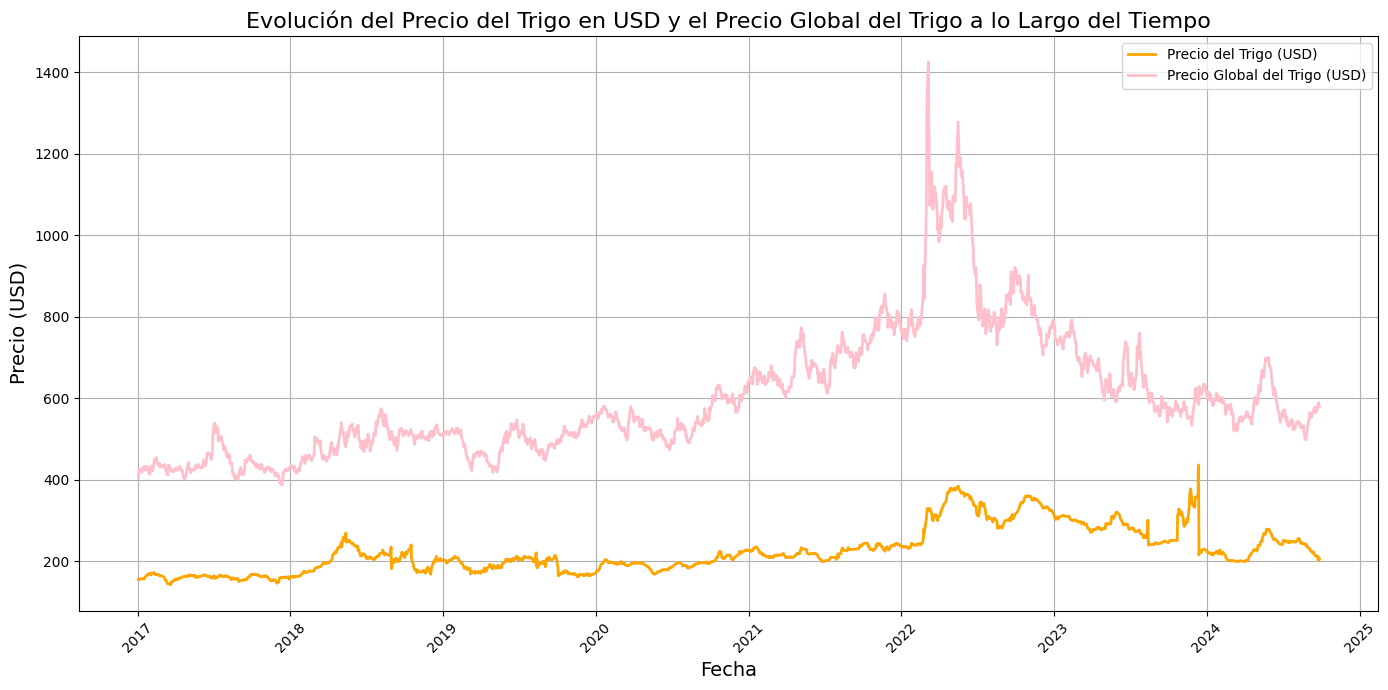

In [ ]:
#Se Grafica el precio del trigo en USD contra el precio global del trigo
plt.figure(figsize=(14, 7))
plt.plot(df_combined_final['fecha'], df_combined_final['precio_en_usd'], label='Precio del Trigo (USD)', color='orange', linewidth=2)
plt.plot(df_combined_final['fecha'], df_combined_final['precio_global'], label='Precio Global del Trigo (USD)', color='pink', linewidth=2)
plt.title('Evolución del Precio del Trigo en USD y el Precio Global del Trigo a lo Largo del Tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio (USD)', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


*Se observa que ambos precios presentan una tendencia general similar, con picos y caídas que se correlacionan en momentos específicos. Esto indica que los precios locales del trigo en Argentina están influenciados por el precio global del trigo*

In [ ]:
#Matriz de correlación con el mapa de calor
df_filtered = df_combined_final[['precio_en_usd', 'precio_petroleo', 'precio_global', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]
correlation_matrix = df_filtered.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Mapa de Calor de Correlaciones con Precio en USD del Trigo")
plt.show()



NameError: name 'df_combined_final' is not defined

A traves de la matriz de correlacion se confirman los factores influentes para el precio del trigo:

**Tipo de Cambio (USD/ARS):** Se detecta una correlación muy fuerte entre el precio del trigo y el tipo de cambio, lo que indica que un aumento en el tipo de cambio (devaluación del peso argentino) está asociado con un aumento en el precio del trigo.*

**Precio en USD y Precio Global del Trigo:** Se observa una fuerte correlación positiva (0.806) entre el precio en USD del trigo en Argentina y el precio global del trigo, sugiriendo que ambos precios tienden a moverse en la misma dirección.

**Precio del Petróleo**: La correlación entre el precio del trigo y el precio del petróleo es también positiva, indicando que el precio del petróleo influye en los costos de producción y por ende en el precio del trigo.

**Temperaturas:** Las temperaturas mínimas (tmin) y máximas (tmax) muestran correlaciones positivas moderadas con el precio del trigo. Esto sugiere que temperaturas más altas podrían estar asociadas con precios más bajos del trigo tal como se observó en graficos anteriores, posiblemente debido a condiciones de estrés en el cultivo u oferta y demanda por epocas de cosecha.

**Precipitación (prcp):** La precipitación también tiene una correlación negativa con el precio del trigo (-0.109), lo que implica que una mayor cantidad de precipitación puede asociarse con precios más bajos

# **Conclusion**
# Este analisis revela que el precio del trigo en Argentina está fuertemente influenciado por varios factores. La influencia del tipo de cambio indica que la devaluación del peso aumenta el precio del trigo en dolar. Además, existe una fuerte relación con el precio global del trigo y el precio del petróleo, lo que sugiere que los costos de producción y las condiciones del mercado internacional son cruciales. Las condiciones climaticas como temperaturas y precipitación son influentes afectando el precio a la baja en condiciones extremas de calor o sequia. Con esta información, podemos prodecer a realizar modelos que intenten predecir el precio del trigo.